In [1]:
!jupyter-kernelspec list

Available kernels:
  ir         /usr/local/share/jupyter/kernels/ir
  python2    /usr/local/share/jupyter/kernels/python2
  python3    /usr/local/share/jupyter/kernels/python3
  swift      /usr/local/share/jupyter/kernels/swift


In [0]:
# activate R magic
%load_ext rpy2.ipython

In [5]:
%%R
library(survival)
library(tidyverse)
dat <- pbc
head(dat)


/usr/local/lib/python3.6/dist-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: ── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python3.6/dist-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: ✔ ggplot2 3.2.1     ✔ purrr   0.3.3
✔ tibble  2.1.3     ✔ dplyr   0.8.3
✔ tidyr   1.0.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.4.0

  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python3.6/dist-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: ── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

  warnings.warn(x, RRuntimeWarning)


  id time status trt      age sex ascites hepato spiders edema bili chol
1  1  400      2   1 58.76523   f       1      1       1   1.0 14.5  261
2  2 4500      0   1 56.44627   f       0      1       1   0.0  1.1  302
3  3 1012      2   1 70.07255   m       0      0       0   0.5  1.4  176
4  4 1925      2   1 54.74059   f       0      1       1   0.5  1.8  244
5  5 1504      1   2 38.10541   f       0      1       1   0.0  3.4  279
6  6 2503      2   2 66.25873   f       0      1       0   0.0  0.8  248
  albumin copper alk.phos    ast trig platelet protime stage
1    2.60    156   1718.0 137.95  172      190    12.2     4
2    4.14     54   7394.8 113.52   88      221    10.6     3
3    3.48    210    516.0  96.10   55      151    12.0     4
4    2.54     64   6121.8  60.63   92      183    10.3     4
5    3.53    143    671.0 113.15   72      136    10.9     3
6    3.98     50    944.0  93.00   63       NA    11.0     3


In [7]:
%%R
summary(dat$time / 365.25)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.1123  2.9918  4.7365  5.2506  7.1554 13.1280 


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  26.28   42.83   51.00   50.74   58.24   78.44 


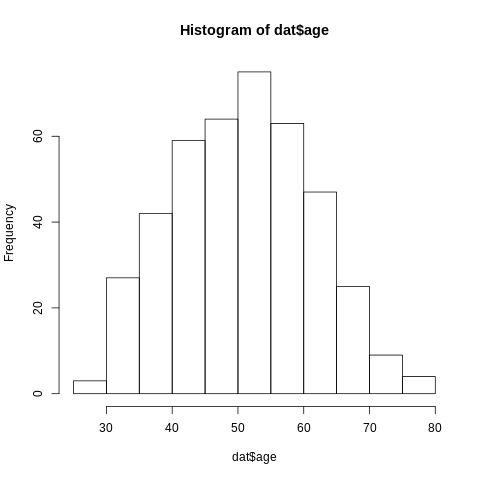

In [8]:
%%R
hist(dat$age)
summary(dat$age)

In [9]:
%%R
## 
table(dat$sex)


  m   f 
 44 374 


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
     41    1093    1730    1918    2614    4795 


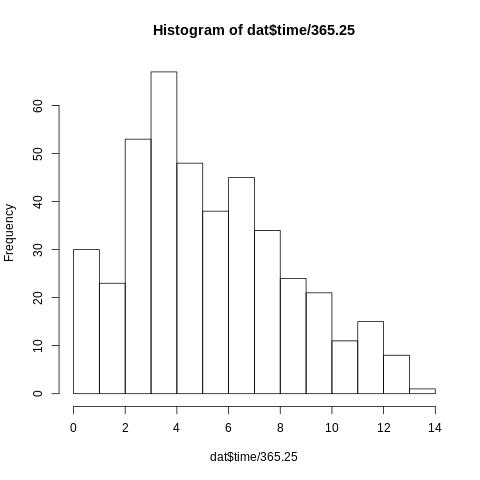

In [10]:
%%R
## distribution of the time to death in year
hist(dat$time/365.25)
summary(dat$time)

In [11]:
%%R
table(dat$status)


  0   1   2 
232  25 161 


In [0]:
%%R
## data preparation and identifying the cesoring variable
dat$newStatus <- ifelse(dat$status != 2, dat$newStatus <- 0, dat$newStatus <- 1)
dat$trt <- ifelse(!is.na(dat$trt), dat$trt <- dat$trt, dat$trt <- 3)
head(dat$status)
head(dat$newStatus)
dat$group <- ifelse(dat$trt == 1, dat$group <- 'D-penicillmain', ifelse(dat$trt == 2, dat$group <- 'placebo', dat$group <- 'not-randomised'))
dat$chol = ifelse(is.na(dat$chol),
                  ave(dat$chol, FUN = function(x) mean(x, na.rm = TRUE)),
                  dat$chol)
dat$albumin = ifelse(is.na(dat$albumin),
                  ave(dat$albumin, FUN = function(x) mean(x, na.rm = TRUE)),
                  dat$albumin)
dat$copper = ifelse(is.na(dat$copper),
                  ave(dat$copper, FUN = function(x) mean(x, na.rm = TRUE)),
                  dat$copper)
dat$alk.phos = ifelse(is.na(dat$alk.phos),
                  ave(dat$alk.phos, FUN = function(x) mean(x, na.rm = TRUE)),
                  dat$alk.phos)
dat$ast = ifelse(is.na(dat$ast),
                  ave(dat$ast, FUN = function(x) mean(x, na.rm = TRUE)),
                  dat$ast)
dat$trig = ifelse(is.na(dat$trig),
                  ave(dat$trig, FUN = function(x) mean(x, na.rm = TRUE)),
                  dat$trig)
dat$platelet = ifelse(is.na(dat$platelet),
                  ave(dat$platelet, FUN = function(x) mean(x, na.rm = TRUE)),
                  dat$platelet)
dat$protime = ifelse(is.na(dat$protime),
                  ave(dat$protime, FUN = function(x) mean(x, na.rm = TRUE)),
                  dat$protime)
dat$ascites = ifelse(!is.na(dat$ascites), dat$ascites, dat$ascites <- 0)
dat$hepato = ifelse(!is.na(dat$hepato), dat$hepato, dat$hepato <- 1)
dat$spiders = ifelse(!is.na(dat$spiders), dat$spiders, dat$spiders <- 0)
dat$stage = ifelse(!is.na(dat$stage), dat$stage, dat$stage <- 2)

In [14]:
%%R
## proportion of newStatus variable
table(dat$newStatus)


  0   1 
257 161 


In [15]:
%%R
table(dat$group)


D-penicillmain not-randomised        placebo 
           158            106            154 


In [16]:
%%R
table(dat$newStatus)


  0   1 
257 161 


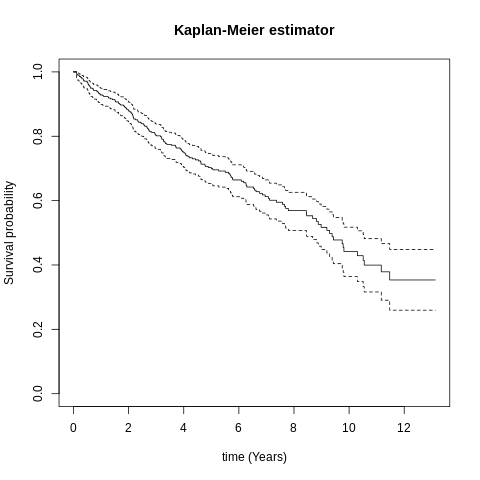

In [17]:
%%R
## Kaplan Meyer Estimator
dat <- mutate(dat, timeYears = time / 365.25)
fit.KM <- survfit(Surv(timeYears, newStatus) ~ 1, data = dat, conf.type = "log-log")
summary(fit.KM)
plot(fit.KM,
     main = "Kaplan-Meier estimator",
     ylab = "Survival probability",
     xlab = "time (Years)")

In [18]:
%%R
## what is the median survival time
fit.KM

Call: survfit(formula = Surv(timeYears, newStatus) ~ 1, data = dat, 
    conf.type = "log-log")

      n  events  median 0.95LCL 0.95UCL 
 418.00  161.00    9.30    8.45   10.51 


In [19]:
%%R
## comparing three groups D-penicillmain, placebo and not randomised
## The log rank test
fit.logrank <- survdiff(Surv(time, newStatus) ~ group, data = dat)
fit.logrank

Call:
survdiff(formula = Surv(time, newStatus) ~ group, data = dat)

                       N Observed Expected (O-E)^2/E (O-E)^2/V
group=D-penicillmain 158       65     64.0    0.0141    0.0235
group=not-randomised 106       36     34.6    0.0573    0.0737
group=placebo        154       60     62.4    0.0892    0.1461

 Chisq= 0.2  on 2 degrees of freedom, p= 0.9 


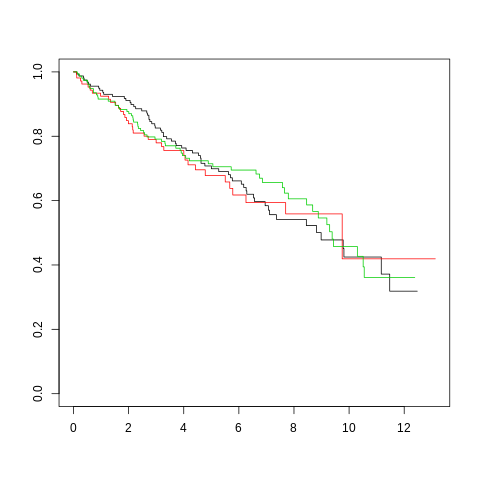

In [20]:
%%R
## the p-value is not significant therefore we don't reject the null hypothesis. the groups are not different from each other. 
fit.KM <- survfit(Surv(timeYears, newStatus) ~ group, data = dat, conf.type = "log-log")
fit.KM
plot(fit.KM, col = 1:3)

In [21]:
%%R
## Logrank test stratifying by sex
survdiff(Surv(time, newStatus) ~ group + strata(sex), data = dat)

Call:
survdiff(formula = Surv(time, newStatus) ~ group + strata(sex), 
    data = dat)

                       N Observed Expected (O-E)^2/E (O-E)^2/V
group=D-penicillmain 158       65     64.3   0.00869    0.0145
group=not-randomised 106       36     34.5   0.06551    0.0846
group=placebo        154       60     62.3   0.08135    0.1334

 Chisq= 0.2  on 2 degrees of freedom, p= 0.9 


In [22]:
%%R
## Logrank test stratifying by holistic stage of disease
survdiff(Surv(time, newStatus) ~ group + strata(stage), data = dat)

Call:
survdiff(formula = Surv(time, newStatus) ~ group + strata(stage), 
    data = dat)

                       N Observed Expected (O-E)^2/E (O-E)^2/V
group=D-penicillmain 158       65     63.6     0.029    0.0489
group=not-randomised 106       36     33.2     0.239    0.3121
group=placebo        154       60     64.2     0.271    0.4645

 Chisq= 0.6  on 2 degrees of freedom, p= 0.8 


In [23]:
%%R
## Logrank test startifying by edema
survdiff(Surv(time, newStatus) ~ group + strata(edema), data = dat)

Call:
survdiff(formula = Surv(time, newStatus) ~ group + strata(edema), 
    data = dat)

                       N Observed Expected (O-E)^2/E (O-E)^2/V
group=D-penicillmain 158       65     65.2  0.000717   0.00123
group=not-randomised 106       36     32.0  0.488430   0.64327
group=placebo        154       60     63.7  0.219444   0.38151

 Chisq= 0.8  on 2 degrees of freedom, p= 0.7 


In [24]:
%%R
## Logrank test sytratifying by hepato
survdiff(Surv(time, newStatus) ~ group + strata(hepato), data = dat)

Call:
survdiff(formula = Surv(time, newStatus) ~ group + strata(hepato), 
    data = dat)

                       N Observed Expected (O-E)^2/E (O-E)^2/V
group=D-penicillmain 158       65     55.5     1.629     2.599
group=not-randomised 106       36     48.2     3.069     5.043
group=placebo        154       60     57.4     0.122     0.195

 Chisq= 5.5  on 2 degrees of freedom, p= 0.06 


In [25]:
%%R
## cox regression ==> exp(beta) refers to unit increase of the regressor. exp(beta) is the hazard ratio . 
#From exp(coef) the not-randomised group has a higher risk, therefore shorter life span. placebo has a lower risk hence longer life span. 
#From both p-values it's clear that the 3 sets of groups are not statistically different from each other. 
fit.cph <- coxph(Surv(time, newStatus) ~ group, data = dat)
summary(fit.cph)

Call:
coxph(formula = Surv(time, newStatus) ~ group, data = dat)

  n= 418, number of events= 161 

                        coef exp(coef) se(coef)      z Pr(>|z|)
groupnot-randomised  0.02560   1.02593  0.20851  0.123    0.902
groupplacebo        -0.05349   0.94792  0.17913 -0.299    0.765

                    exp(coef) exp(-coef) lower .95 upper .95
groupnot-randomised    1.0259     0.9747    0.6818     1.544
groupplacebo           0.9479     1.0549    0.6673     1.347

Concordance= 0.512  (se = 0.024 )
Likelihood ratio test= 0.16  on 2 df,   p=0.9
Wald test            = 0.16  on 2 df,   p=0.9
Score (logrank) test = 0.16  on 2 df,   p=0.9



In [26]:
%%R
## running cox regression on a continuous covariate. From the p-value it is clear that age is a statistically significatnt covariate in how the patients respond to the various treatment methods. 
#The HR is 1.04 which implies that as a patient grows older by 1 year the risk of death increases by 4 percent. the scale of the covariate is age in years. 
#+ve coeffient ==> beta the higher the age the higher the risk of dying
fit.cph1 <- coxph(Surv(time, newStatus) ~ age, data = dat)
summary(fit.cph1)

Call:
coxph(formula = Surv(time, newStatus) ~ age, data = dat)

  n= 418, number of events= 161 

        coef exp(coef) se(coef)     z Pr(>|z|)    
age 0.039185  1.039963 0.007847 4.994 5.92e-07 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

    exp(coef) exp(-coef) lower .95 upper .95
age      1.04     0.9616     1.024     1.056

Concordance= 0.616  (se = 0.023 )
Likelihood ratio test= 25.19  on 1 df,   p=5e-07
Wald test            = 24.94  on 1 df,   p=6e-07
Score (logrank) test = 25.3  on 1 df,   p=5e-07



In [0]:
%%R
## Automatic model selection based on AIC
Mfull <- coxph(Surv(timeYears, newStatus) ~ age + sex + ascites + hepato + spiders + stage +
                 albumin + group + copper + alk.phos + ast + trig + platelet + bili + chol + 
                 edema + protime, data = dat)

In [28]:
%%R
MAIC <- step(Mfull)

Start:  AIC=1561.21
Surv(timeYears, newStatus) ~ age + sex + ascites + hepato + spiders + 
    stage + albumin + group + copper + alk.phos + ast + trig + 
    platelet + bili + chol + edema + protime

           Df    AIC
- group     2 1557.5
- spiders   1 1559.2
- platelet  1 1559.2
- alk.phos  1 1559.2
- chol      1 1559.7
- sex       1 1559.7
- ascites   1 1560.1
- hepato    1 1560.2
<none>        1561.2
- trig      1 1561.2
- copper    1 1562.9
- ast       1 1563.1
- edema     1 1564.8
- protime   1 1565.0
- albumin   1 1566.6
- age       1 1570.2
- stage     1 1570.9
- bili      1 1585.6

Step:  AIC=1557.49
Surv(timeYears, newStatus) ~ age + sex + ascites + hepato + spiders + 
    stage + albumin + copper + alk.phos + ast + trig + platelet + 
    bili + chol + edema + protime

           Df    AIC
- spiders   1 1555.5
- platelet  1 1555.5
- alk.phos  1 1555.5
- sex       1 1555.9
- chol      1 1556.0
- ascites   1 1556.3
- hepato    1 1557.0
- trig      1 1557.3
<none>        1557